In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='whitegrid', font_scale=0.8)

from memoization import cached

%run ../modules/plotting_metrics.py
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

In [2]:
# Hold-out and Cross Validation

In [33]:
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

In [ ]:
## f-Fold Cross Validation

# Stratified k-fold Cross Validation

In [202]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

@cached()
def _train_validate(clf, clf_name, 
                    X_train, X_test, y_train, y_test,
                    metric_name, metric_params):
    if clf_name.startswith('ml_'):
        # Fit the estimator
        clf.fit(X_train, y_train)
        # Make the predictions
        y_pred = clf.predict_proba(X_test)[:,1]
    elif clf_name.startswith('cs_'):
        # apply consensus
        y_pred = clf(pd.DataFrame(X_test))
    else:
        print(clf_name, 'not found. Ommited.')
        return

    # Make the evaluation
    metric = PlotMetric(y_test, {'': y_pred},
                decreasing=False)\
                .format_metric_results(
                    rounded=5,
                    metric_name=metric_name,
                    **metric_params)

    return metric.values[0][0]

@cached()
def _do_replicates(splits, estimators, X, y,
          metric_name='roc_auc', metric_params={}):
    results={}
    # Machine Learning Classifiers
    for clf_name, clf in estimators.items():
        folds = []
        for i, (train, test) in enumerate(splits):
            metric = _train_validate(
                clf, clf_name, 
                X[train], X[test], y[train], y[test],
                metric_name, metric_params
            )
            # Append the results
            folds.append(metric)

        # Add to the results dictonary 
        results['$'.join([clf_name])] = folds

    return results

@cached()
def k_cross_validation(estimators, X, y,
          metric_name='roc_auc', metric_params={},
          n_splits=5, 
          random_state=None, shuffle=True):
    # Compute the Stratified K folds
    cv = StratifiedKFold(n_splits=n_splits, 
                         random_state=random_state,
                         shuffle=shuffle)
    splits = [*cv.split(X, y)]
    
    results = _do_replicates(splits, estimators, X, y,
          metric_name, metric_params)
    
    return results

@cached()
def n_hold_out_validation(estimators, X, y,
          metric_name='roc_auc', metric_params={},
          n_reps=5, test_size=0.25,
          random_state=None):
    # Compute the Stratified K folds
    cv = StratifiedShuffleSplit(
                        n_splits=n_reps, 
                        test_size=test_size,
                        random_state=random_state)
    splits = [*cv.split(X, y)]
    
    results = _do_replicates(splits, estimators, X, y,
          metric_name, metric_params)
    
    return results

In [238]:
def plot_swarm_metrics(df_results, metric_name):
    df_melted = pd.melt(df, var_name='method', value_name=metric_name)

    fig, ax = plt.subplots(figsize=(12,6))
    ax = sns.swarmplot(data=df_melted, x='method', y=metric_name)
    ax.set(
        title=f'ML vs CS results: {metric_name.replace("_", " ").upper()}',
           xlabel='VS Method')


## Classifiers and consensus Scorings
### ML Classifiers

In [170]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified"}
dclf = DummyClassifier(**hyparams)

In [171]:
from sklearn.neighbors import KNeighborsClassifier

hyparams ={'n_neighbors': 1, 'n_jobs': 4}
knn = KNeighborsClassifier(**hyparams)

In [172]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [173]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

In [174]:
from sklearn.ensemble import RandomForestClassifier

hyparams = {'n_estimators': 100, 'min_samples_split': 10,
            'min_samples_leaf': 4, 
            'max_features': 'sqrt', 'max_depth': 10}
rf = RandomForestClassifier(**hyparams)

In [191]:
# ML Classifier
ml_classifiers = {
    'dclf': dclf,
    'knn': knn,
    'lr': lr,
    'xgb': xgb,
    'rf': rf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [192]:
cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
    'VOTE': get_vote_score,
    'RANK': get_rank_score 
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

## Estimators dictionary

In [193]:
estimators = {**ml_classifiers, **cs_functions}

# Cross Validation

In [241]:
%%time
metric_name='roc_auc'
results = k_cross_validation(estimators, X, y, n_splits=5, random_state=42)

df_res = pd.DataFrame(results)
plot_swarm_metrics(df_res, metric_name=)

TypeError: plot_swarm_metrics() missing 1 required positional argument: 'metric_name'

[Text(0.5, 1.0, 'ML vs CS results: ROC AUC'), Text(0.5, 0, 'VS Method')]

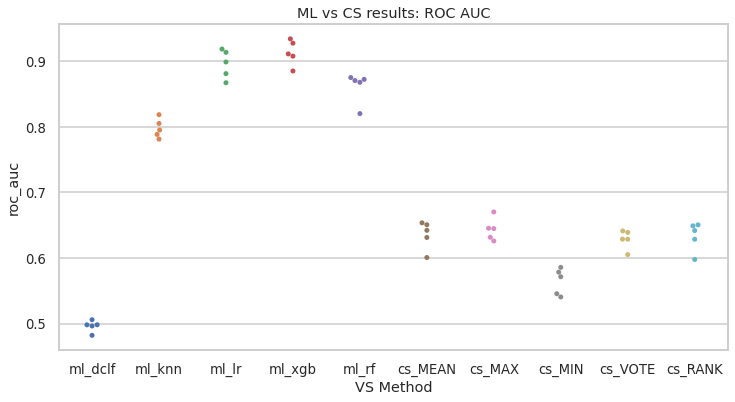

In [199]:
random_state=42
metric_name='roc_auc'

a = k_cross_validation(estimators, X, y, random_state=42)
b = n_hold_out_validation(estimators, X, y, random_state=42)

print(a)
print(b)

TypeError: unhashable type: 'dict'

/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

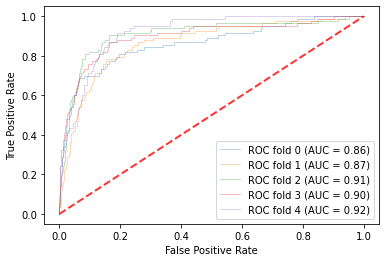

In [38]:


cv = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()